### Module import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
cd /content/drive/MyDrive/gradcam/

/content/drive/MyDrive/gradcam


In [3]:
import os
import PIL
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

###Define Variables

In [4]:
models_path = 'models'
# models_name = ['alexnet', 'vgg16', 'resnet50', resnet18, 'densenet121',]
models_name = ['densenet121']
# models_name = ['vgg16']
# models_name = ['resnet18']
# models_name = ['resnet50']
# models_name = ['alexnet']



out_features = 3

img_dir = 'images'
img_name = 'Copy of 20190724_132431_hf.jpg'

### Load image

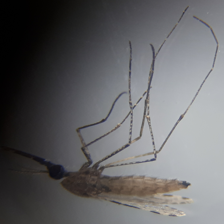

In [5]:
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img.resize((224,224))

### preprocess image

In [7]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


### Load trained or pretrained models and make model dictionaries

In [8]:
cam_dict = dict()

for model_name in models_name:
    if (model_name == 'resnet18'):
        # -------------- Resnet18 ---------------------
        model_ft = models.resnet18(pretrained=True)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features=num_ftrs, out_features=out_features)
        if model_name+'.pth' in os.listdir(models_path):
            state_dict = torch.load(os.path.join(models_path, model_name+'.pth'))
            model_ft.load_state_dict(state_dict)
            print('resnet18 the model loaded....')
        model_ft.eval(), model_ft.cuda();
        resnet_model_dict = dict(type='resnet18', arch=model_ft, layer_name='layer4', input_size=(224, 224))
        resnet_gradcam = GradCAM(resnet_model_dict, True)
        resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
        cam_dict['resnet18'] = [resnet_gradcam, resnet_gradcampp]
        
    elif (model_name == 'resnet50'):
        # -------------- Resnet50  -------------------
        model_ft = models.resnet50(pretrained=True)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features=num_ftrs, out_features=out_features)
        if model_name+'.pth' in os.listdir(models_path):
            state_dict = torch.load(os.path.join(models_path, model_name+'.pth'))
            model_ft.load_state_dict(state_dict)
            print('resnet50 the model loaded....')
        model_ft.eval(), model_ft.cuda();
        resnet_model_dict = dict(type='resnet50', arch=model_ft, layer_name='layer4', input_size=(224, 224))
        resnet_gradcam = GradCAM(resnet_model_dict, True)
        resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
        cam_dict['resnet50'] = [resnet_gradcam, resnet_gradcampp]

    elif (model_name == 'densenet121'):
        # --------------Dense Net  -------------------
        model_ft = models.densenet121(pretrained=True)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(in_features=num_ftrs, out_features=out_features)
        if model_name+'.pth' in os.listdir(models_path):
            state_dict = torch.load(os.path.join(models_path, model_name+'.pth'))
            model_ft.load_state_dict(state_dict)
            print('densenet121 the model loaded....')
        model_ft.eval(), model_ft.cuda();
        densenet_model_dict = dict(type='densenet', arch=model_ft, layer_name='features_denseblock3', input_size=(224, 224))
        densenet_gradcam = GradCAM(densenet_model_dict, True)
        densenet_gradcampp = GradCAMpp(densenet_model_dict, True)
        cam_dict['densenet'] = [densenet_gradcam, densenet_gradcampp]

    elif (model_name == 'vgg16'):
        # -------------- VGG16_bn  ------------------ 
        model_ft = models.vgg16_bn(pretrained=True)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(in_features= num_ftrs ,out_features=out_features )
        if model_name+'.pth' in os.listdir(models_path):
            state_dict = torch.load(os.path.join(models_path, model_name+'.pth'))
            model_ft.load_state_dict(state_dict)
            print('vgg16bn the model loaded....')
        model_ft.eval(), model_ft.cuda();
        vgg_model_dict = dict(type='vgg', arch=model_ft, layer_name='features_29', input_size=(224, 224))
        vgg_gradcam = GradCAM(vgg_model_dict, True)
        vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
        cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

    elif (model_name == 'alexnet'):
        # ----------------Alexnet  -------------------
        model_ft = models.alexnet(pretrained=True)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(in_features= num_ftrs ,out_features=out_features )
        if model_name+'.pth' in os.listdir(models_path):
            state_dict = torch.load(os.path.join(models_path, model_name+'.pth'))
            model_ft.load_state_dict(state_dict)
            print('alexnet the model loaded....')
        model_ft.eval(), model_ft.cuda();
        alexnet_model_dict = dict(type='alexnet', arch=model_ft, layer_name='features_11', input_size=(224, 224))
        alexnet_gradcam = GradCAM(alexnet_model_dict, True)
        alexnet_gradcampp = GradCAMpp(alexnet_model_dict, True)
        cam_dict['alexnet'] = [alexnet_gradcam, alexnet_gradcampp]      


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



densenet121 the model loaded....
saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([14, 14])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


### Feedforward image, calculate GradCAM/GradCAM++, and gather results

In [9]:
images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask.cpu(), torch_img.cpu())

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp.cpu(), torch_img.cpu())
    
    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    
images = make_grid(torch.cat(images, 0), nrow=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


### Save and show results 

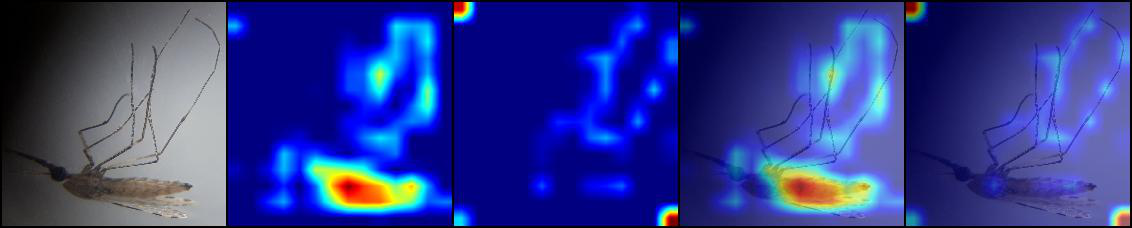

In [10]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)

In [ ]:
!pwd